# **Hiperparaméter-hangolás**
Készítette: *Fogarassyné Vathy Ágnes*


## **1. Az optima telepítése**

In [1]:
!pip install optuna

import optuna
print('Optuna verzió:', optuna.__version__)

Optuna verzió: 4.5.0


/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## **2. Az adathalmaz előkészítése**

**Blokk 2.1** OLvassuk be és készítsük elő a Titanic adathalmazt.

In [2]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
from sklearn.model_selection import train_test_split

# DataFrame létrehozása Excel fájlból
#titanic = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/1_KorszDM_I/2_Osztalyozas/Titanic.xlsx')
titanic = pd.read_excel('Titanic.xlsx')

# Eldobjuk a NAME oszlopot
titanic.drop(labels='Name', axis=1, inplace=True)

# Dummy váltóvá konvertáljuk a SEX oszlopot (referencia kódolással, ezért csak 1 oszlop lesz belőle)
titanic['Sex'] = pd.get_dummies(titanic['Sex'], drop_first=True)

# DataFrame-et TULAJDONSÁGOK(features, X) és CÉL(target, y) tömbökre bontjuk
X = titanic.iloc[:, 1:].values
y = titanic.iloc[:, 0].values.reshape(-1,1)

# Tréning és teszt adatok létrehozása 2/3 és 1/3 vágással
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)

## **3. Optuna**

Az **objective(trial)** függvény az Optuna számára írja le egy próba (trial) értékelését. Minden trial-ban az Optuna mintát vesz az alkalmazott gépi tanuló algoritmus (jelen esetben Random Forest) fontos hiperparamétereiből, létrehoz egy modellt ezekkel az értékekkel, majd keresztvalidációval (StratifiedKFold) becsüli a teljesítményt:

- *trial.suggest_int(...)*: a keresési tér definiálása egész értékekre
- *StratifiedKFold*: keresztvalidáció meghatározása
- *cross_val_score(..., scoring="accuracy")*: kiértékelés (a metrika itt a pontosság (Accuracy), az öt fold átlaga lesz az objective értéke, amit az Optuna maximalizál)

**Blokk 3.1** Definiáljuk az Optuna objective függvényét.

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score

# --- Optuna objective ---
def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 500)
    max_depth = trial.suggest_int("max_depth", 2, 30)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)

    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        n_jobs=-1,
        random_state=42
    )

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X, y, cv=cv, scoring="accuracy", n_jobs=-1)

    return scores.mean()

**Blokk 3.2** Hajtsuk végre az Optunával a hiperparaméter keresést.

- Egy kísérletsorozatot a **create_study**-val tudunk létrehozni, ahol a *direction="maximize"* beállítással meghatározzuk, hogy a célja az objective függvény által visszaadott érték maximalizálása.
- A **study.optimize** végrehajtja a hiperparaméterek optimalizálsát. Jelen esetben 50 próbát futtat: minden próbában az Optuna új hiperparaméter-kombinációt javasol, kiértékeli azt az objective-ben, és naplózza az eredményt.

In [5]:
# --- Optimalizálás futtatása ---
sampler = optuna.samplers.TPESampler(seed=42)
pruner = optuna.pruners.MedianPruner(n_startup_trials=10, n_warmup_steps=0)

study = optuna.create_study(direction='maximize', sampler=sampler, pruner=pruner)

study.optimize(objective, n_trials=50, show_progress_bar=True)


[I 2025-10-04 10:45:48,047] A new study created in memory with name: no-name-5fa3a9a3-64f2-4f1f-8095-cc31de053051
  0%|          | 0/50 [00:00<?, ?it/s]/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator

[I 2025-10-04 10:45:49,476] Trial 0 finished with value: 0.8083539643242557 and parameters: {'n_estimators': 218, 'max_depth': 29, 'min_samples_split': 15, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.8083539643242557.


/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
Best trial: 0. Best value: 0.808354:   4%|▍         | 2/50 [00:02<00:58,  1.22s/it]/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/

[I 2025-10-04 10:45:50,550] Trial 1 finished with value: 0.8027232908017521 and parameters: {'n_estimators': 120, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.8083539643242557.


Best trial: 0. Best value: 0.808354:   6%|▌         | 3/50 [00:02<00:38,  1.21it/s]/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/

[I 2025-10-04 10:45:50,910] Trial 2 finished with value: 0.8049958738018155 and parameters: {'n_estimators': 321, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.8083539643242557.


Best trial: 3. Best value: 0.818498:   8%|▊         | 4/50 [00:03<00:30,  1.50it/s]/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/

[I 2025-10-04 10:45:51,330] Trial 3 finished with value: 0.8184980638608519 and parameters: {'n_estimators': 425, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 3 with value: 0.8184980638608519.


Best trial: 3. Best value: 0.818498:  10%|█         | 5/50 [00:03<00:22,  2.00it/s]/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/

[I 2025-10-04 10:45:51,535] Trial 4 finished with value: 0.8162445248524092 and parameters: {'n_estimators': 187, 'max_depth': 17, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 3 with value: 0.8184980638608519.


Best trial: 3. Best value: 0.818498:  12%|█▏        | 6/50 [00:03<00:19,  2.27it/s]/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/

[I 2025-10-04 10:45:51,859] Trial 5 finished with value: 0.8151209293467911 and parameters: {'n_estimators': 325, 'max_depth': 6, 'min_samples_split': 7, 'min_samples_leaf': 4}. Best is trial 3 with value: 0.8184980638608519.


Best trial: 3. Best value: 0.818498:  14%|█▍        | 7/50 [00:04<00:16,  2.65it/s]/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/

[I 2025-10-04 10:45:52,108] Trial 6 finished with value: 0.8117437948327304 and parameters: {'n_estimators': 255, 'max_depth': 24, 'min_samples_split': 5, 'min_samples_leaf': 6}. Best is trial 3 with value: 0.8184980638608519.


Best trial: 3. Best value: 0.818498:  16%|█▌        | 8/50 [00:04<00:14,  2.86it/s]/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/

[I 2025-10-04 10:45:52,396] Trial 7 finished with value: 0.7982225607820732 and parameters: {'n_estimators': 317, 'max_depth': 3, 'min_samples_split': 13, 'min_samples_leaf': 2}. Best is trial 3 with value: 0.8184980638608519.
[I 2025-10-04 10:45:52,496] Trial 8 finished with value: 0.8117374468355234 and parameters: {'n_estimators': 79, 'max_depth': 29, 'min_samples_split': 20, 'min_samples_leaf': 9}. Best is trial 3 with value: 0.8184980638608519.


Best trial: 3. Best value: 0.818498:  20%|██        | 10/50 [00:04<00:10,  3.98it/s]/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13

[I 2025-10-04 10:45:52,683] Trial 9 finished with value: 0.808341268329842 and parameters: {'n_estimators': 187, 'max_depth': 4, 'min_samples_split': 15, 'min_samples_leaf': 5}. Best is trial 3 with value: 0.8184980638608519.


Best trial: 10. Best value: 0.828655:  22%|██▏       | 11/50 [00:05<00:12,  3.22it/s]/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.1

[I 2025-10-04 10:45:53,170] Trial 10 finished with value: 0.8286548593918619 and parameters: {'n_estimators': 476, 'max_depth': 12, 'min_samples_split': 9, 'min_samples_leaf': 1}. Best is trial 10 with value: 0.8286548593918619.


Best trial: 11. Best value: 0.829772:  24%|██▍       | 12/50 [00:05<00:13,  2.82it/s]/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.1

[I 2025-10-04 10:45:53,644] Trial 11 finished with value: 0.829772106900273 and parameters: {'n_estimators': 482, 'max_depth': 12, 'min_samples_split': 8, 'min_samples_leaf': 1}. Best is trial 11 with value: 0.829772106900273.


Best trial: 11. Best value: 0.829772:  26%|██▌       | 13/50 [00:06<00:14,  2.51it/s]/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.1

[I 2025-10-04 10:45:54,160] Trial 12 finished with value: 0.8252586808861805 and parameters: {'n_estimators': 487, 'max_depth': 12, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 11 with value: 0.829772106900273.


Best trial: 13. Best value: 0.830915:  28%|██▊       | 14/50 [00:06<00:14,  2.47it/s]/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.1

[I 2025-10-04 10:45:54,583] Trial 13 finished with value: 0.8309147463975115 and parameters: {'n_estimators': 418, 'max_depth': 13, 'min_samples_split': 8, 'min_samples_leaf': 1}. Best is trial 13 with value: 0.8309147463975115.


Best trial: 13. Best value: 0.830915:  30%|███       | 15/50 [00:06<00:14,  2.45it/s]/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.1

[I 2025-10-04 10:45:54,994] Trial 14 finished with value: 0.8207706468609153 and parameters: {'n_estimators': 408, 'max_depth': 16, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 13 with value: 0.8309147463975115.


Best trial: 13. Best value: 0.830915:  32%|███▏      | 16/50 [00:07<00:13,  2.44it/s]/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.1

[I 2025-10-04 10:45:55,407] Trial 15 finished with value: 0.8275122198946232 and parameters: {'n_estimators': 406, 'max_depth': 11, 'min_samples_split': 13, 'min_samples_leaf': 1}. Best is trial 13 with value: 0.8309147463975115.


Best trial: 13. Best value: 0.830915:  34%|███▍      | 17/50 [00:07<00:13,  2.53it/s]/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.1

[I 2025-10-04 10:45:55,770] Trial 16 finished with value: 0.8106138513299055 and parameters: {'n_estimators': 374, 'max_depth': 16, 'min_samples_split': 7, 'min_samples_leaf': 7}. Best is trial 13 with value: 0.8309147463975115.


Best trial: 13. Best value: 0.830915:  36%|███▌      | 18/50 [00:08<00:13,  2.39it/s]/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.1

[I 2025-10-04 10:45:56,242] Trial 17 finished with value: 0.8151272773439979 and parameters: {'n_estimators': 496, 'max_depth': 21, 'min_samples_split': 12, 'min_samples_leaf': 4}. Best is trial 13 with value: 0.8309147463975115.


Best trial: 13. Best value: 0.830915:  38%|███▊      | 19/50 [00:08<00:12,  2.39it/s]/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.1

[I 2025-10-04 10:45:56,664] Trial 18 finished with value: 0.8196280073636768 and parameters: {'n_estimators': 436, 'max_depth': 9, 'min_samples_split': 19, 'min_samples_leaf': 2}. Best is trial 13 with value: 0.8309147463975115.


Best trial: 13. Best value: 0.830915:  40%|████      | 20/50 [00:08<00:12,  2.47it/s]/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.1

[I 2025-10-04 10:45:57,037] Trial 19 finished with value: 0.8252650288833874 and parameters: {'n_estimators': 364, 'max_depth': 18, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 13 with value: 0.8309147463975115.


Best trial: 13. Best value: 0.830915:  42%|████▏     | 21/50 [00:09<00:12,  2.41it/s]/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.1

[I 2025-10-04 10:45:57,475] Trial 20 finished with value: 0.8117374468355234 and parameters: {'n_estimators': 456, 'max_depth': 13, 'min_samples_split': 8, 'min_samples_leaf': 7}. Best is trial 13 with value: 0.8309147463975115.


Best trial: 13. Best value: 0.830915:  44%|████▍     | 22/50 [00:09<00:12,  2.32it/s]/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.1

[I 2025-10-04 10:45:57,946] Trial 21 finished with value: 0.8241350853805625 and parameters: {'n_estimators': 460, 'max_depth': 13, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 13 with value: 0.8309147463975115.


Best trial: 13. Best value: 0.830915:  46%|████▌     | 23/50 [00:10<00:11,  2.25it/s]/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.1

[I 2025-10-04 10:45:58,418] Trial 22 finished with value: 0.829765758903066 and parameters: {'n_estimators': 488, 'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 1}. Best is trial 13 with value: 0.8309147463975115.


Best trial: 13. Best value: 0.830915:  48%|████▊     | 24/50 [00:10<00:11,  2.19it/s]/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.1

[I 2025-10-04 10:45:58,905] Trial 23 finished with value: 0.8196216593664699 and parameters: {'n_estimators': 500, 'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 2}. Best is trial 13 with value: 0.8309147463975115.


Best trial: 13. Best value: 0.830915:  50%|█████     | 25/50 [00:11<00:11,  2.24it/s]/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.1

[I 2025-10-04 10:45:59,328] Trial 24 finished with value: 0.8263886243890053 and parameters: {'n_estimators': 382, 'max_depth': 14, 'min_samples_split': 11, 'min_samples_leaf': 1}. Best is trial 13 with value: 0.8309147463975115.


Best trial: 13. Best value: 0.830915:  52%|█████▏    | 26/50 [00:11<00:10,  2.21it/s]/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.1

[I 2025-10-04 10:45:59,793] Trial 25 finished with value: 0.824147781374976 and parameters: {'n_estimators': 450, 'max_depth': 19, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 13 with value: 0.8309147463975115.


Best trial: 13. Best value: 0.830915:  54%|█████▍    | 27/50 [00:12<00:10,  2.29it/s]/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.1

[I 2025-10-04 10:46:00,195] Trial 26 finished with value: 0.8207579508665017 and parameters: {'n_estimators': 404, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 4}. Best is trial 13 with value: 0.8309147463975115.


Best trial: 13. Best value: 0.830915:  56%|█████▌    | 28/50 [00:12<00:08,  2.46it/s]/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.1

[I 2025-10-04 10:46:00,532] Trial 27 finished with value: 0.8094775598298737 and parameters: {'n_estimators': 343, 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 13 with value: 0.8309147463975115.


Best trial: 13. Best value: 0.830915:  58%|█████▊    | 29/50 [00:12<00:07,  2.68it/s]/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.1

[I 2025-10-04 10:46:00,825] Trial 28 finished with value: 0.8117437948327304 and parameters: {'n_estimators': 294, 'max_depth': 7, 'min_samples_split': 15, 'min_samples_leaf': 1}. Best is trial 13 with value: 0.8309147463975115.


Best trial: 13. Best value: 0.830915:  60%|██████    | 30/50 [00:13<00:07,  2.57it/s]/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.1

[I 2025-10-04 10:46:01,252] Trial 29 finished with value: 0.8117374468355234 and parameters: {'n_estimators': 436, 'max_depth': 14, 'min_samples_split': 17, 'min_samples_leaf': 5}. Best is trial 13 with value: 0.8309147463975115.


Best trial: 13. Best value: 0.830915:  62%|██████▏   | 31/50 [00:13<00:06,  2.92it/s]/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.1

[I 2025-10-04 10:46:01,477] Trial 30 finished with value: 0.7824414397257665 and parameters: {'n_estimators': 230, 'max_depth': 2, 'min_samples_split': 11, 'min_samples_leaf': 2}. Best is trial 13 with value: 0.8309147463975115.


Best trial: 13. Best value: 0.830915:  64%|██████▍   | 32/50 [00:13<00:06,  2.62it/s]/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.1

[I 2025-10-04 10:46:01,959] Trial 31 finished with value: 0.830889354408684 and parameters: {'n_estimators': 475, 'max_depth': 11, 'min_samples_split': 9, 'min_samples_leaf': 1}. Best is trial 13 with value: 0.8309147463975115.


Best trial: 13. Best value: 0.830915:  66%|██████▌   | 33/50 [00:14<00:07,  2.43it/s]/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.1

[I 2025-10-04 10:46:02,442] Trial 32 finished with value: 0.8309083984003047 and parameters: {'n_estimators': 472, 'max_depth': 15, 'min_samples_split': 8, 'min_samples_leaf': 1}. Best is trial 13 with value: 0.8309147463975115.


Best trial: 13. Best value: 0.830915:  68%|██████▊   | 34/50 [00:14<00:06,  2.33it/s]/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.1

[I 2025-10-04 10:46:02,910] Trial 33 finished with value: 0.8252840728750079 and parameters: {'n_estimators': 463, 'max_depth': 15, 'min_samples_split': 8, 'min_samples_leaf': 2}. Best is trial 13 with value: 0.8309147463975115.


Best trial: 13. Best value: 0.830915:  70%|███████   | 35/50 [00:15<00:06,  2.32it/s]/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.1

[I 2025-10-04 10:46:03,349] Trial 34 finished with value: 0.8241414333777692 and parameters: {'n_estimators': 426, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 13 with value: 0.8309147463975115.


Best trial: 35. Best value: 0.833156:  72%|███████▏  | 36/50 [00:15<00:06,  2.29it/s]/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.1

[I 2025-10-04 10:46:03,793] Trial 35 finished with value: 0.8331555894115408 and parameters: {'n_estimators': 386, 'max_depth': 24, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 35 with value: 0.8331555894115408.


Best trial: 35. Best value: 0.833156:  74%|███████▍  | 37/50 [00:16<00:05,  2.32it/s]/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.1

[I 2025-10-04 10:46:04,215] Trial 36 finished with value: 0.8286485113946551 and parameters: {'n_estimators': 374, 'max_depth': 26, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 35 with value: 0.8331555894115408.


Best trial: 35. Best value: 0.833156:  76%|███████▌  | 38/50 [00:16<00:04,  2.47it/s]/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.1

[I 2025-10-04 10:46:04,560] Trial 37 finished with value: 0.801606043293341 and parameters: {'n_estimators': 347, 'max_depth': 30, 'min_samples_split': 6, 'min_samples_leaf': 10}. Best is trial 35 with value: 0.8331555894115408.


Best trial: 35. Best value: 0.833156:  78%|███████▊  | 39/50 [00:16<00:04,  2.33it/s]/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.1

[I 2025-10-04 10:46:05,043] Trial 38 finished with value: 0.8241414333777692 and parameters: {'n_estimators': 397, 'max_depth': 25, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 35 with value: 0.8331555894115408.


Best trial: 35. Best value: 0.833156:  80%|████████  | 40/50 [00:17<00:03,  2.57it/s]/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.1

[I 2025-10-04 10:46:05,339] Trial 39 finished with value: 0.8061004253158128 and parameters: {'n_estimators': 281, 'max_depth': 22, 'min_samples_split': 4, 'min_samples_leaf': 8}. Best is trial 35 with value: 0.8331555894115408.
[I 2025-10-04 10:46:05,512] Trial 40 finished with value: 0.8196153113692631 and parameters: {'n_estimators': 147, 'max_depth': 18, 'min_samples_split': 11, 'min_samples_leaf': 4}. Best is trial 35 with value: 0.8331555894115408.


Best trial: 35. Best value: 0.833156:  84%|████████▍ | 42/50 [00:17<00:02,  2.68it/s]/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.1

[I 2025-10-04 10:46:06,001] Trial 41 finished with value: 0.8263886243890053 and parameters: {'n_estimators': 437, 'max_depth': 11, 'min_samples_split': 8, 'min_samples_leaf': 1}. Best is trial 35 with value: 0.8331555894115408.


Best trial: 42. Best value: 0.835409:  86%|████████▌ | 43/50 [00:18<00:02,  2.43it/s]/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.1

[I 2025-10-04 10:46:06,503] Trial 42 finished with value: 0.8354091284199834 and parameters: {'n_estimators': 468, 'max_depth': 15, 'min_samples_split': 7, 'min_samples_leaf': 1}. Best is trial 42 with value: 0.8354091284199834.


Best trial: 42. Best value: 0.835409:  88%|████████▊ | 44/50 [00:18<00:02,  2.29it/s]/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.1

[I 2025-10-04 10:46:06,994] Trial 43 finished with value: 0.8241414333777692 and parameters: {'n_estimators': 464, 'max_depth': 15, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 42 with value: 0.8354091284199834.


Best trial: 42. Best value: 0.835409:  90%|█████████ | 45/50 [00:19<00:02,  2.30it/s]/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.1

[I 2025-10-04 10:46:07,430] Trial 44 finished with value: 0.8342791849171587 and parameters: {'n_estimators': 424, 'max_depth': 17, 'min_samples_split': 7, 'min_samples_leaf': 1}. Best is trial 42 with value: 0.8354091284199834.


Best trial: 42. Best value: 0.835409:  92%|█████████▏| 46/50 [00:19<00:01,  2.33it/s]/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.1

[I 2025-10-04 10:46:07,842] Trial 45 finished with value: 0.8286548593918617 and parameters: {'n_estimators': 418, 'max_depth': 27, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 42 with value: 0.8354091284199834.


Best trial: 42. Best value: 0.835409:  94%|█████████▍| 47/50 [00:20<00:01,  2.37it/s]/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.1

[I 2025-10-04 10:46:08,245] Trial 46 finished with value: 0.8342791849171587 and parameters: {'n_estimators': 389, 'max_depth': 23, 'min_samples_split': 7, 'min_samples_leaf': 1}. Best is trial 42 with value: 0.8354091284199834.


Best trial: 42. Best value: 0.835409:  96%|█████████▌| 48/50 [00:20<00:00,  2.50it/s]/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.1

[I 2025-10-04 10:46:08,594] Trial 47 finished with value: 0.8275185678918302 and parameters: {'n_estimators': 320, 'max_depth': 22, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 42 with value: 0.8354091284199834.


Best trial: 42. Best value: 0.835409:  98%|█████████▊| 49/50 [00:20<00:00,  2.57it/s]/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.1

[I 2025-10-04 10:46:08,962] Trial 48 finished with value: 0.8354027804227766 and parameters: {'n_estimators': 357, 'max_depth': 28, 'min_samples_split': 7, 'min_samples_leaf': 1}. Best is trial 42 with value: 0.8354091284199834.


Best trial: 42. Best value: 0.835409: 100%|██████████| 50/50 [00:21<00:00,  2.35it/s]

[I 2025-10-04 10:46:09,293] Trial 49 finished with value: 0.8218878943693264 and parameters: {'n_estimators': 341, 'max_depth': 28, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 42 with value: 0.8354091284199834.


## 4. Eredmények vizualizációja

**Blokk 4.1** Az optuna folyamatosan logolta az eredményeket, így lehetőségünk van a futtatást követően vizualizálni a részeredményeket is. Néhány fontosabb diagram:

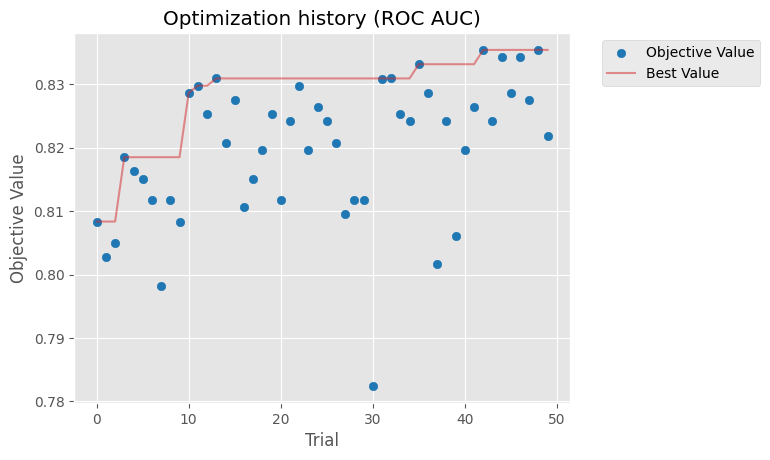

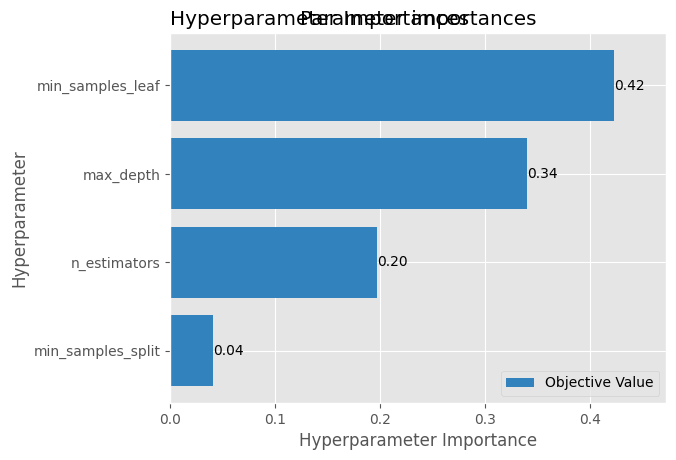

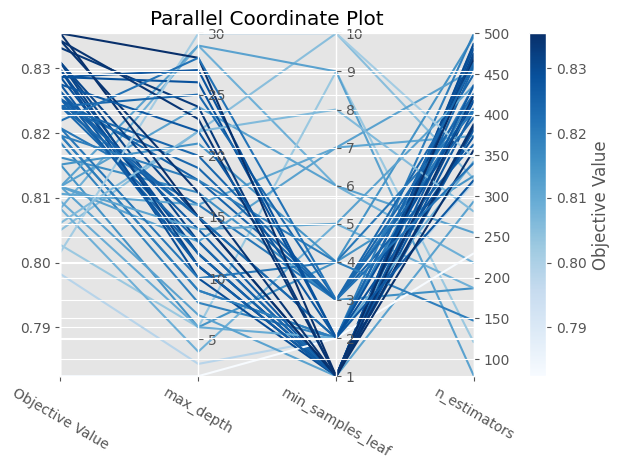

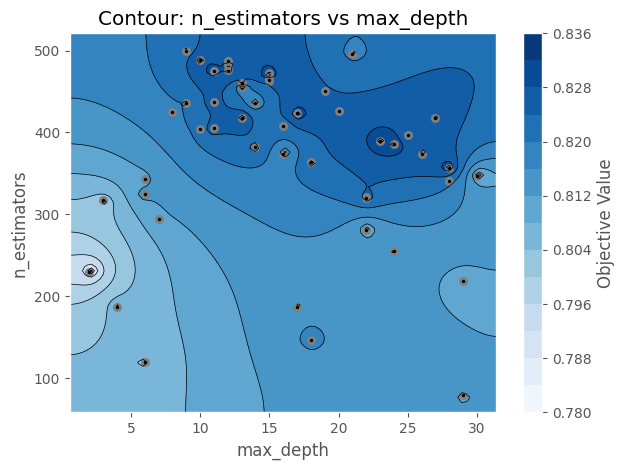

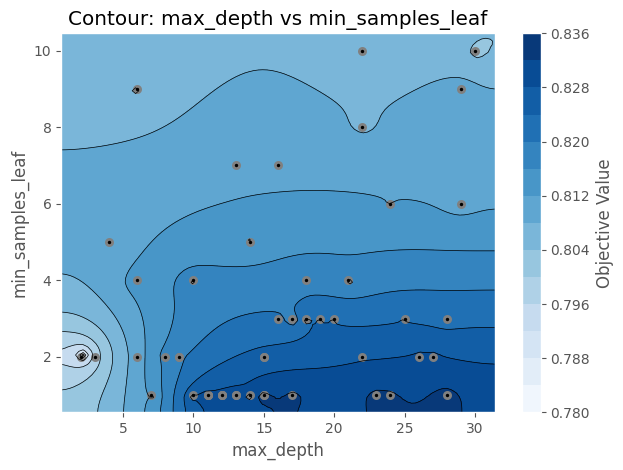

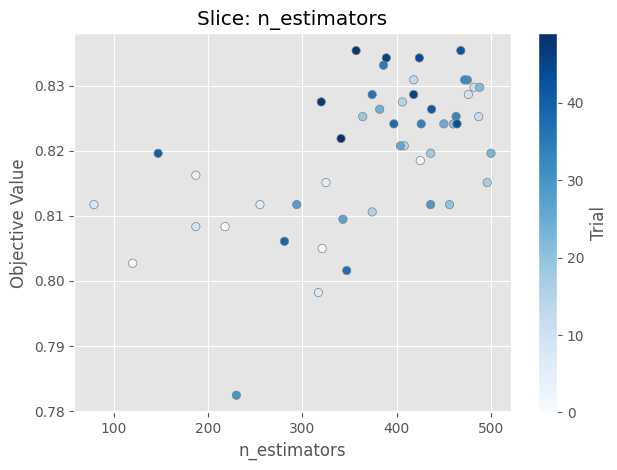

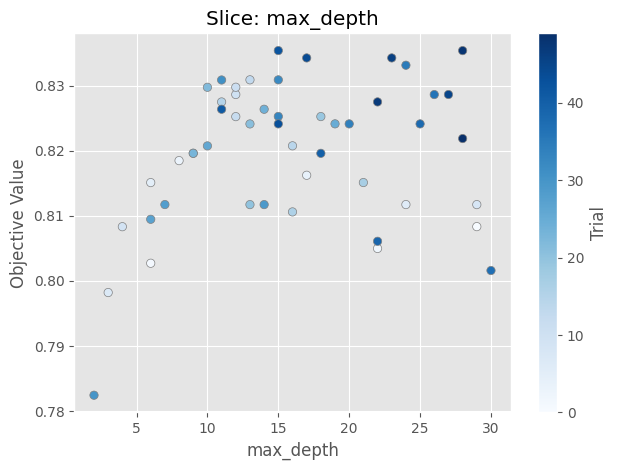

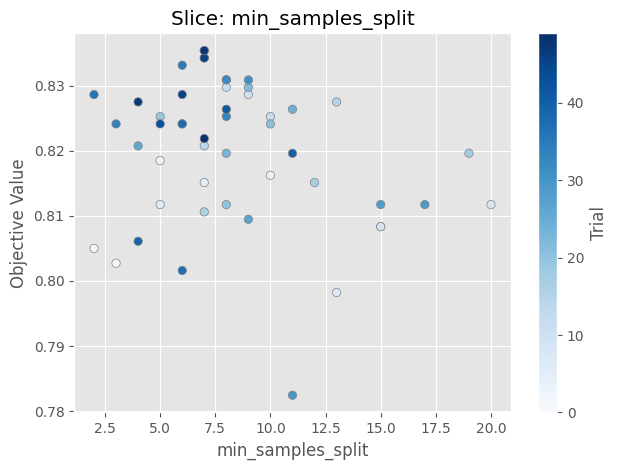

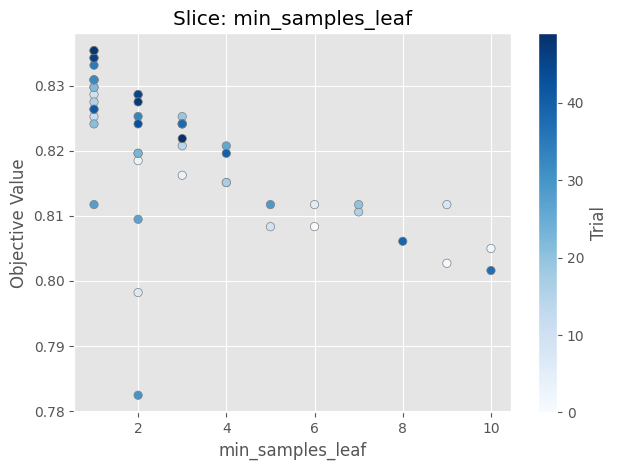

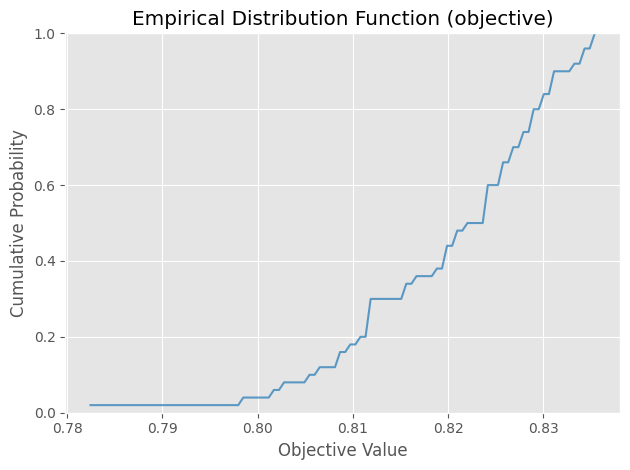

In [6]:
import matplotlib.pyplot as plt
from optuna.exceptions import ExperimentalWarning
warnings.filterwarnings("ignore", category=ExperimentalWarning)

from optuna.visualization.matplotlib import (
     plot_optimization_history,
     plot_param_importances,
     plot_parallel_coordinate,
     plot_contour,
     plot_slice,
     plot_edf,
     plot_rank)

# Hogyan változott a célfüggvény értéke próbáról próbára
_ = plot_optimization_history(study)
plt.title('Optimization history (ROC AUC)')
plt.show()

# Becsült paraméterfontosságok
_ = plot_param_importances(study)
plt.title('Parameter importances')
plt.show()


# Párhuzamos tengelyek? párhuzamos tengelyek: több paraméter együttes hatása a célértékre
# Paraméterek a párhuzamos tengelyekhez
params_to_plot = [
    "n_estimators",
    "max_depth",
    "min_samples_leaf"]

_ = plot_parallel_coordinate(study, params=params_to_plot)
plt.tight_layout()
plt.show()

# Contour: Két kontúrtérkép két paraméter terében a kombinációk jósága
_ = plot_contour(study, params=["n_estimators", "max_depth"])
plt.title("Contour: n_estimators vs max_depth")
plt.tight_layout()
plt.show()

_ = plot_contour(study, params=["max_depth", "min_samples_leaf"])
plt.title("Contour: max_depth vs min_samples_leaf")
plt.tight_layout()
plt.show()

# Slice: egy paraméter értékei vs. célérték pontfelhő
for p in ["n_estimators", "max_depth", "min_samples_split", "min_samples_leaf"]:
    _ = plot_slice(study, params=[p])
    plt.title(f"Slice: {p}")
    plt.tight_layout()
    plt.show()

# Empirikus eloszlásfüggvény
_ = plot_edf(study)
plt.title("Empirical Distribution Function (objective)")
plt.tight_layout()
plt.show()



## 5. A legjobb modell kiértékelése

**Blokk 5.1** A legjobb kombináció kiértékelése és a legjobb hiperparaméterkombináció értékei:



In [7]:
# --- Eredmények ---
print("Legjobb pontosság:", study.best_value)
print("Legjobb paraméterek:", study.best_trial.params)

Legjobb pontosság: 0.8354091284199834
Legjobb paraméterek: {'n_estimators': 468, 'max_depth': 15, 'min_samples_split': 7, 'min_samples_leaf': 1}


## 6. Legjobb modell újratanítása és kiértékelése

**Blokk 6.1** Illesszük újra a legjobb paraméterekkel a modellt, majd értékeljük ki...

/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Pontosság (test): 0.8225255972696246


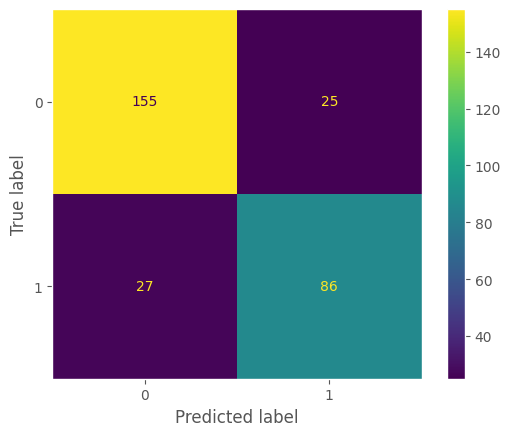

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt

best_params = study.best_trial.params
best_model = RandomForestClassifier(
    n_estimators=best_params["n_estimators"],
    max_depth=best_params["max_depth"],
    min_samples_split=best_params["min_samples_split"],
    min_samples_leaf=best_params["min_samples_leaf"],
    n_jobs=-1,
    random_state=42
)
best_model.fit(X_train, y_train)

# Prediktálás és kiértékelés
y_pred = best_model.predict(X_test)
print("Pontosság (test):", accuracy_score(y_test, y_pred))


cm_dtree = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_dtree)
disp.plot()
disp.ax_.grid(False)

# Keveredési mátrix kirajzolása
#cm = confusion_matrix(y_test, y_pred)
#disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
#disp.plot(values_format='d')
#plt.title("Confusion Matrix – Holdout test")
#plt.show()
